In [57]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [58]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./trainlyrics.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 106526624
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [59]:
# Get a random sequence of rock lyrics.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [60]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [61]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        self.num_layers = 4
        
        self.rnn = nn.RNN(self.input_size, self.hidden_size, num_layers=self.num_layers, dropout=0.2, nonlinearity="relu")
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        output, hidden = self.rnn(input, hidden)
        output = self.linear(output)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(self.num_layers, self.hidden_size).to(device) #made into a 2d tensor. 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNN(100, 100, num_layers=4, dropout=0.2)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [62]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [63]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [64]:
# Number of iterations.
# NOTE: You may reduce the number of training iterations if the training takes long.
iters       = 20000  # Number of training iterations.
print_iters = 1000    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.001) #changed learning rate from 0.005 to 0.001
loss_func = nn.CrossEntropyLoss() 

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/20000 loss:3.374668598175049
generated sequence: WSaum O  klfte des' boaeTao eiithelerinu yotseo i dood.t pttdwlldo  Tted  senweareg  orkalcsn)lnyydeT

iter:199/20000 loss:3.111201763153076
generated sequence: Weue"vi Tovl(encwar   aerG zhai pn EnY
uetmedt moNmde Heativik lry @aC ga f s  Sen' To huvl aiy aeonh

iter:299/20000 loss:2.952479600906372
generated sequence: Weenon utes
An to yuegy too thele 
Gon 
do woe Iho itgy teta a
.liup
whun ke,l,ee p-i psAedet tho bab

iter:399/20000 loss:2.7824947834014893
generated sequence: W meysrt {u oilanast giuyekyates sell klsl gst bbs ch maas
im tyle te Wi
War'Cd YaiO'

rocuy tiu tuur

iter:499/20000 loss:2.6368160247802734
generated sequence: Wong touu 
 Bse
ml wass oSd se wirkp
salr shad'hd
ins net me Twal, onse 
Fe
a me
wyetl si hod
yuf run

iter:599/20000 loss:2.5992953777313232
generated sequence: Wom Soa
aiot
Whil you nre Yoye fuviyde woudt raug Rray
nid the rer 'aEwdr
Toek an lor what iI'ind
tha

iter:699/20000 loss:2.5827419757

#### Training Loss Curve

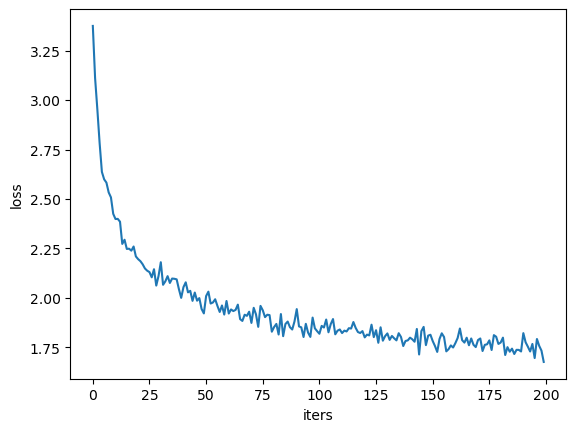

In [65]:
items = [ele.item() for ele in all_losses] 
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(items)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [66]:
print(eval_step(net, predicted_len=600))

Wed all be
Where end is last hroll a had be
Stide shosercount I want
Don't don't fell out I'm sees or to brow no far
it's not me taking alout you grincion one
We've graws

Come, mrough sore ageirs plob wife?
Well it'll deep
who'll wait got a widnarder
I'm so forget to deece a teen feeling
Are me more, the curtter Uy

Wey!, thitk
And goin' my fany ow live ricthing it so a we sloar you
And a cord into to ness it knows pain
Thet sometit must, bling to so turn the munnce's days, but skewing
Oh..'a agoun
Mathing droin as see now, would vea
So eyes thats my bright apay...aw
Ur, you've donna
If I rati
